In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set()
from matplotlib import gridspec

In [52]:
df = pd.read_csv('card.csv', header = [0,1])
np.random.seed(1234)
length = len(df)
df.sample(n = int(length/4))
df.head(5)
df.dtypes
n = len(df[df[('Y', 'default payment next month')]  == 1])
n

6636

In [53]:
print("Fraudulent Cases: " + str(len(df[df[('Y', 'default payment next month')]  == 1])))
print("Valid Transactions: " + str(len(df[df[('Y', 'default payment next month')]  == 0])))
print("Proportion of Fraudulent Cases: " + str(len(df[df[('Y', 'default payment next month')]  == 1])/ df.shape[0]))

Fraudulent Cases: 6636
Valid Transactions: 23364
Proportion of Fraudulent Cases: 0.2212


<AxesSubplot:ylabel=' '>

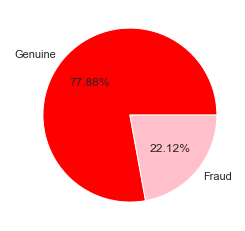

In [54]:
df_p = df.copy()
df_p[" "] = np.where(df_p[('Y', 'default payment next month')] == 1 ,  "Fraud", "Genuine")
df_p[" "].value_counts().plot.pie(autopct = '%.2f%%', colors = ['red','pink'])

In [55]:
#Check missing values
df.isnull().shape[0]
print("Non-missing values: " + str(df.isnull().shape[0]))
print("Missing values: " + str(df.shape[0] - df.isnull().shape[0]))

Non-missing values: 30000
Missing values: 0


c:\Users\evely\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\evely\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\evely\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

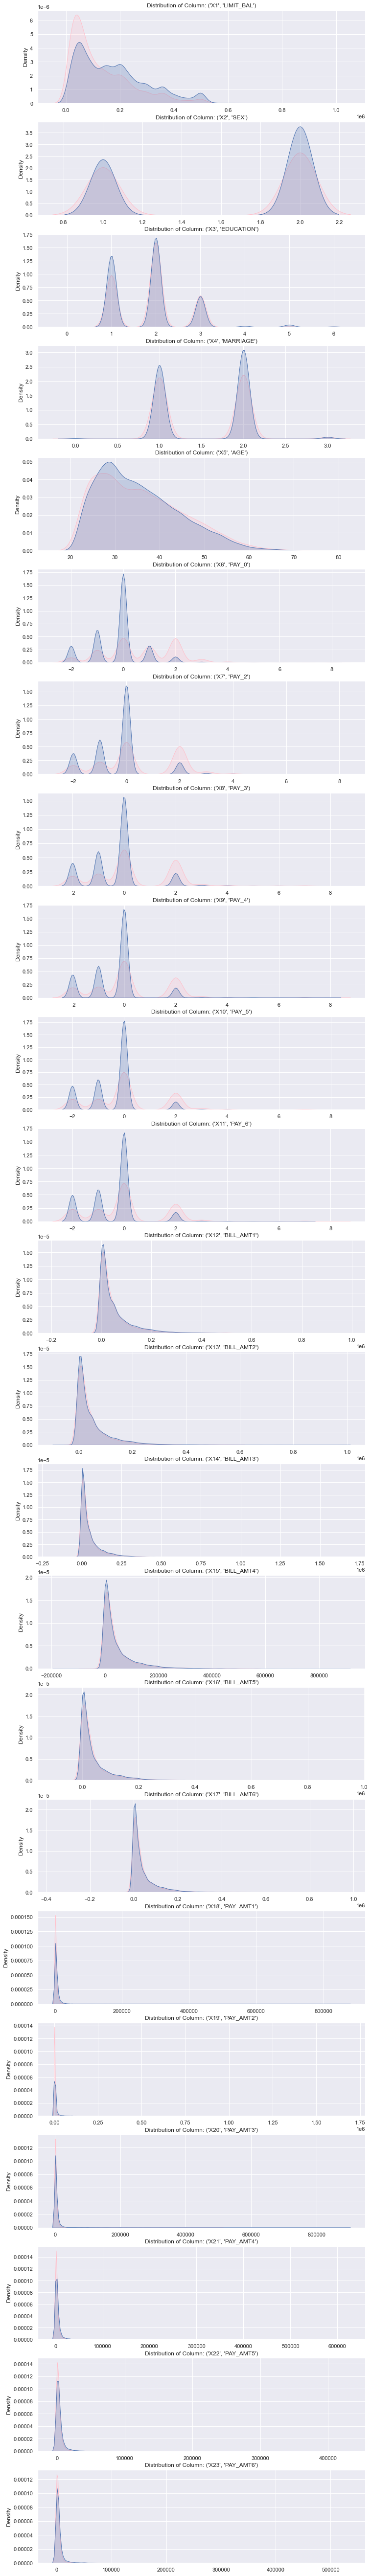

In [56]:
# Plot the distributions of the features
columns = df.iloc[:,1:24].columns
plt.figure(figsize=(12,24*4))
grids = gridspec.GridSpec(23, 1)
for grid, index in enumerate(df[columns]):
 ax = plt.subplot(grids[grid])
 sns.distplot(df[index][df[("Y","default payment next month")] == 1], hist = False, kde_kws = {"shade": True}, color = "pink", bins=50)
 sns.distplot(df[index][df[("Y","default payment next month")] == 0], hist = False, kde_kws = {"shade": True}, bins=50)
 ax.set_xlabel("")
 ax.set_title("Distribution of Column: "  + str(index))
plt.show()


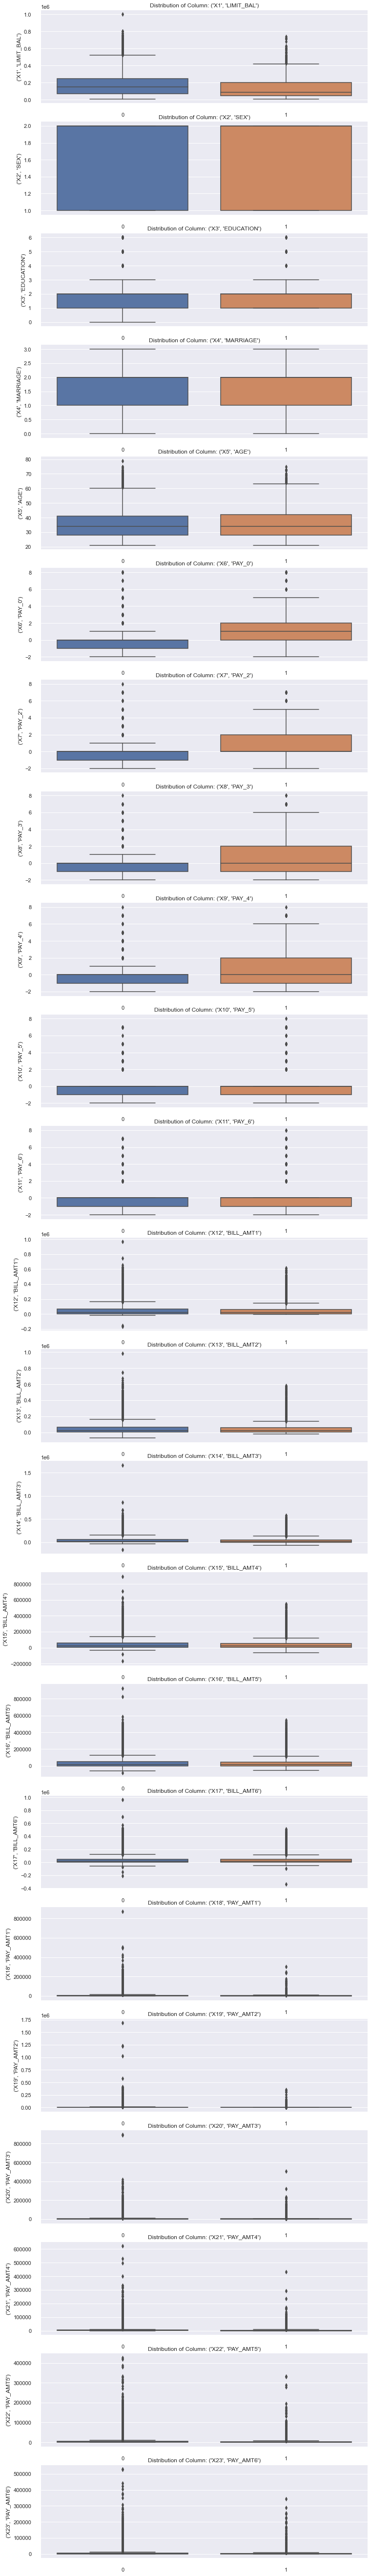

In [83]:
#Boxplots to observe outliers
columns = df.iloc[:,1:24].columns
plt.figure(figsize=(12,24*4))
grids = gridspec.GridSpec(23, 1)
for grid, index in enumerate(df[columns]):
 ax = plt.subplot(grids[grid])
 sns.boxplot(x = ('Y','default payment next month'), y = index, data = df) 
 ax.set_xlabel("")
 ax.set_title("Distribution of Column: "  + str(index))
 sns.despine(offset=10, trim=True) 
 fig.set_size_inches(22,18)
plt.show()

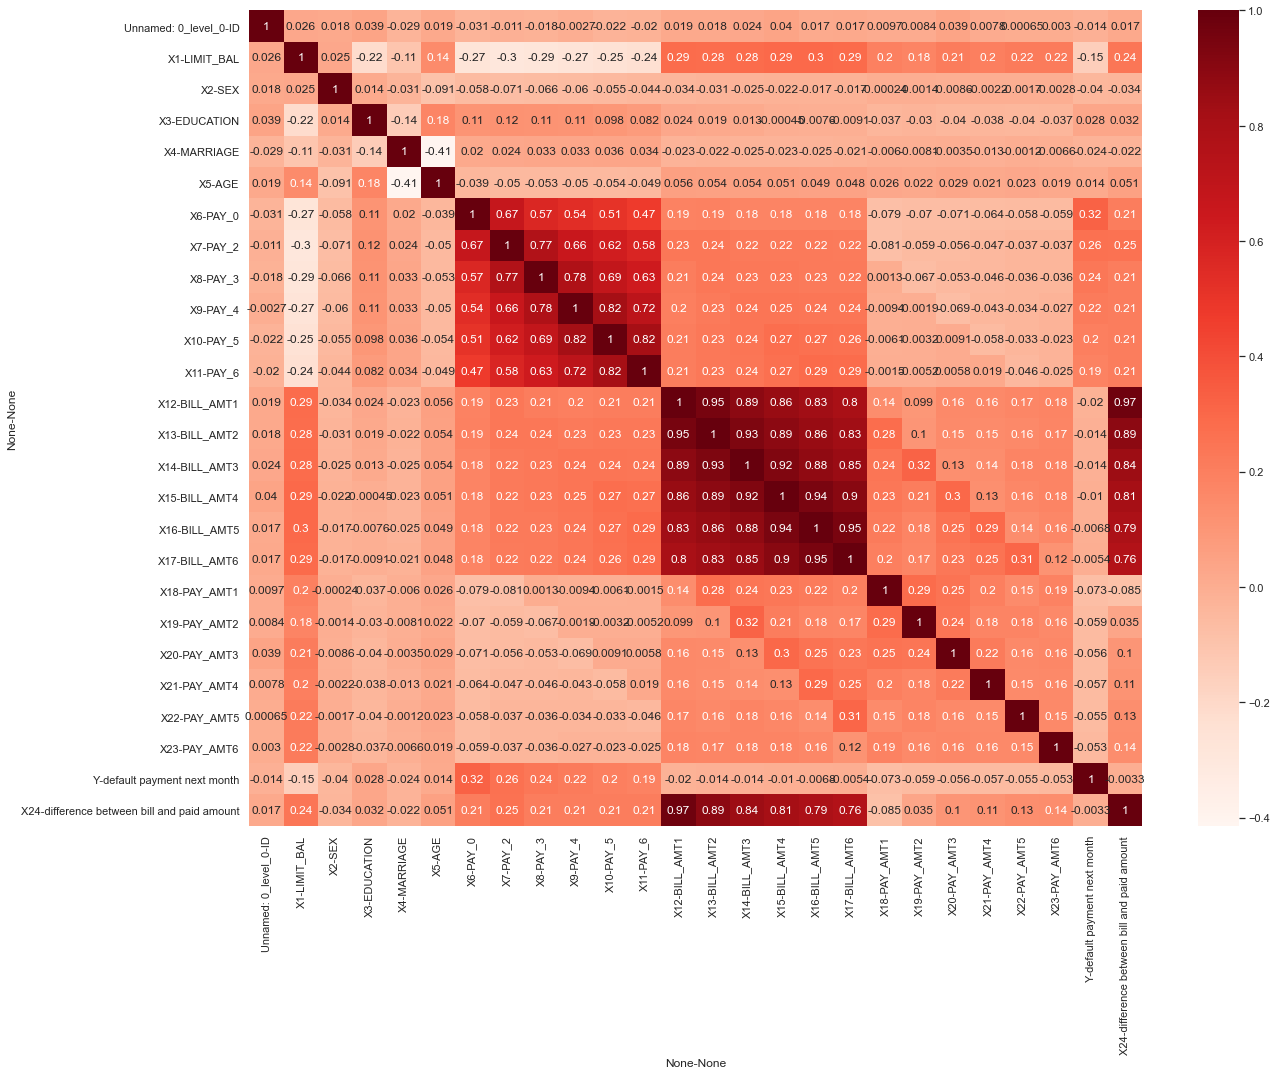

In [90]:
#Using Pearson Correlation
df[('X24', 'difference between bill and paid amount')] = df[('X12', 'BILL_AMT1')] - df[('X18', 'PAY_AMT1')]
plt.figure(figsize=(20,15))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#Using the filter method, there are no clear features to select for the model
#df.plot.bar(x = ('X2', 'SEX'), y = ('Y','default payment next month'))

In [94]:
%pip install statsmodels
import statsmodels.api as sm
y = df[('Y', 'default payment next month')]
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues
#Wrapper method, Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

Note: you may need to restart the kernel to use updated packages.
[('X1', 'LIMIT_BAL'), ('X2', 'SEX'), ('X3', 'EDUCATION'), ('X4', 'MARRIAGE'), ('X5', 'AGE'), ('X6', 'PAY_0'), ('X7', 'PAY_2'), ('X8', 'PAY_3'), ('X10', 'PAY_5'), ('X12', 'BILL_AMT1'), ('X13', 'BILL_AMT2'), ('X18', 'PAY_AMT1'), ('X19', 'PAY_AMT2')]


In [95]:
#split data into train and test set (1/3 test, 2/3 train)
y = df[("Y", "default payment next month")] # target 
X = df.iloc[:,0:24]

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( 
        X, y, test_size = 0.3, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21000, 24), (9000, 24), (21000,), (9000,))

In [65]:
#Create cross validation framework
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

kf = StratifiedKFold(n_splits=10, random_state = None, shuffle = False)

In [63]:
#Import imbalance learn module
from imblearn.pipeline import make_pipeline ## Create a Pipeline using the provided estimators .
from imblearn.under_sampling import NearMiss  ## perform Under-sampling  based on NearMiss methods. 
from imblearn.over_sampling import SMOTE  ## PerformOver-sampling class that uses SMOTE. 
# import the metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
# Import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [66]:
#Random Forest
rfc = RandomForestClassifier() 
rfc.fit(X_train, y_train) 
y_pred = rfc.predict(X_test)

# For the performance let's use some metrics from SKLEARN module
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
  
print("The accuracy is", accuracy_score(y_test, y_pred)) 
print("The precision is", precision_score(y_test, y_pred))
print("The recall is", recall_score(y_test, y_pred))
print("The F1 score is", f1_score(y_test, y_pred))

The accuracy is 0.8164164164164164
The precision is 0.636650868878357
The recall is 0.3697247706422018
The F1 score is 0.4677887405687754


In [67]:
# Fit and predict
rfc = RandomForestClassifier() 
rfc.fit(X_train, y_train) 
y_pred = rfc.predict(X_test)

# For the performance let's use some metrics from SKLEARN module
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
  
print("The accuracy is", accuracy_score(y_test, y_pred)) 
print("The precision is", precision_score(y_test, y_pred))
print("The recall is", recall_score(y_test, y_pred))
print("The F1 score is", f1_score(y_test, y_pred))

The accuracy is 0.815915915915916
The precision is 0.6367281475541299
The recall is 0.3642201834862385
The F1 score is 0.4633790487306682
